# Tutorial Episode 0: Setting up a Factor Analysis pipeline

In this notebook, I show you how to set up a factor analysis pipeline and demonstrate the different methods used for calculating the number of factors to retain.

In [1]:
import os
import sys
sys.path.append(os.path.pardir)

%matplotlib inline
import numpy as np

from fa_kit import FactorAnalysis
from fa_kit import plotting as fa_plotting

## Synthesizing fake data

This function will generate samples of fake data and store it in the `n_samples-by-n_features` matrix `data`.

The data is constructed so that there's structure in the data for the factor analysis to reveal. Specifically, there are 'bands' of 10 adjacent dimensions that are positively correlated with one another. And just to spice things up a bit more, each of these bands is slightly overlapped with it's neighbor.

In [2]:
def make_random_data(n_samp=10000, n_feat=100):
    """
    make some random data with correlated features
    """
    data = np.random.randn(n_samp, n_feat)
    
    signal_width = 10
    signal_overlap = 2
    step_size = signal_width - signal_overlap
    for i in range(0, data.shape[1], step_size):
        shared_signal = 0.3*np.random.randn(n_samp, 1)
        data[:, i:(i+signal_width)] += shared_signal
    return data

data = make_random_data()

## Setting up a factor analysis pipeline

The function `run_pipeline` will take a set of data and run through each of the steps in a factor analysis:
* Import the data and turn it into a `n_features-by-n_features` correlation matrix
* Extract the components using eigendecomposition
* Determine how many components to retain using one of the following methods:
    * Retain Top N comps
    * Retain Fixed percentage of variance
    * Kaiser's criterion
    * Comparison with broken-stick distribution
* Re-extract the *k* retained components using Principle Axis Factoring (PAF)
* Apply factor rotation using one these methods:
    * Varimax
    * Quartimax
* Make a pretty picture to summarize the results

In [3]:
def run_pipeline(data, retain_method='broken_stick',
    rotation_method='varimax', **kwargs):

    # Set up the factor analysis object, indiate how to calculate the
    # correlation matrix out of this input data.

    fa = FactorAnalysis.load_data_samples(
        data,
        preproc_demean=True,
        preproc_scale=True
        )

    # Extract the components
    fa.extract_components()

    # Calculate how many components to retain
    # You can use any of these methods:
    #   'top_n', 'top_pct', 'kaiser', 'broken_stick'

    fa.find_comps_to_retain(
        method=retain_method,
        **kwargs
        )

    # Once you know how many to retain, re-extract with PAF
    fa.reextract_using_paf()

    # Apply factor rotation
    # Right now there are both 'varimax' and 'quartimax'
    fa.rotate_components(
        method=rotation_method
        )

    # Plot summary figure
    fig_summary = fa_plotting.graph_summary(fa)
    
    return fig_summary

### Demo: Top N retention

Below, we see the results when we run the pipeline while using the 'keep the top 5 components' retention method. The top panel in the graph is a scree-plot that shows us how the first 30 eigenvalues are distributed, and puts a dotted line where we set our top-5 cutoff. Looking at the graph, we should probably extract more than 5 components -- it looks like there's a natural dropoff at 12.

The middle panel shows us the five un-rotated components, and the lower panel shows us the five retained components after applying PAF and factor rotation. Even though we've under-extracted the number of components we need, there's still some clear structure with adjacent features loading onto the same components.

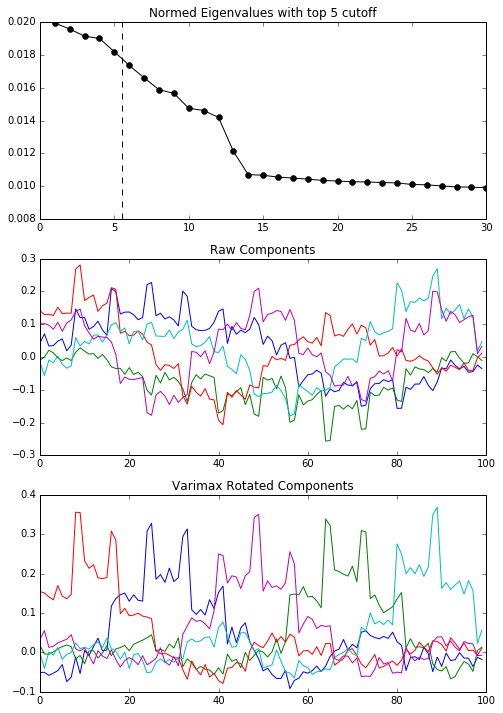

In [4]:
fig_topn = run_pipeline(data, retain_method='top_n', num_keep=5)

### Demo: Top Percentage retention

Up next, we run the analysis using `top_pct` to keep however many components we need to capture a certain proportion of the overall covariance. We've set our cutoff to retain the top 20% of the overall signal.

The top panel has changed and now shows the cumulative proportion of variance explained and we have our cutoff placed at the 20% mark. In this view, it's harder to see the natural cutoff that occurs after the 12th component, but it's still there. And our 20% retention criteria *almost* gets there and decides to keep 11 components. The lower two panels are the same as the previous figure, but now with more components the banded structure of the input becomes more apparent.

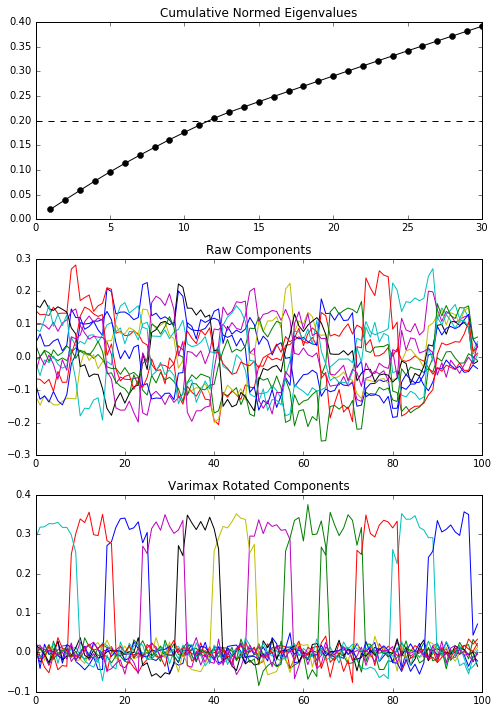

In [5]:
fig_toppct = run_pipeline(data, retain_method='top_pct', pct_keep=0.2)

### Demo: Kaiser's criterion

Now we use Kaiser's criterion to deteremine the number to retain. This criterion is inferred automatically from the dimension of the input data, but as you can see it really over-extracts and the factors look to be split up and noisy.

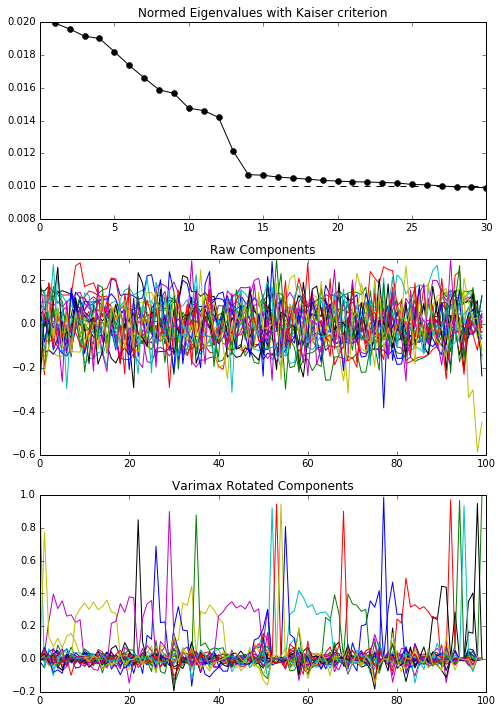

In [6]:
fig_kaiser = run_pipeline(data, retain_method='kaiser')

### Demo: Best-fit Broken-stick

The distribution of eigenvalues in a covariance/correlation matrix often follow what appears to be a broken-stick distribution. Anecdotally, I've had a lot of luck with this method but often found that the broken stick didn't *quite* line up the way you'd expect. So, I've cooked up this variant that does a best-fit of a broken stick to the eigenvalue distribution. There's a little bit of magic in how it works to make sure that the fit isn't overly sensitive to the values in the first couple of components (because those are the ones that we expect to deviate from the broken stick and capture structure/signal).

Another benefit of this modified broken stick is that the method can be used with other types of `n_features-by-n_features` feature similariy matrices, such as co-occurance matrices, mutual information scores, etc.

However, as you'll see in Episode 2, it doesn't *always* do what you want. It's still a work in progress, but overall I'm really happy with how well it does as a fully-automatic method for calculating the number of features to retain.


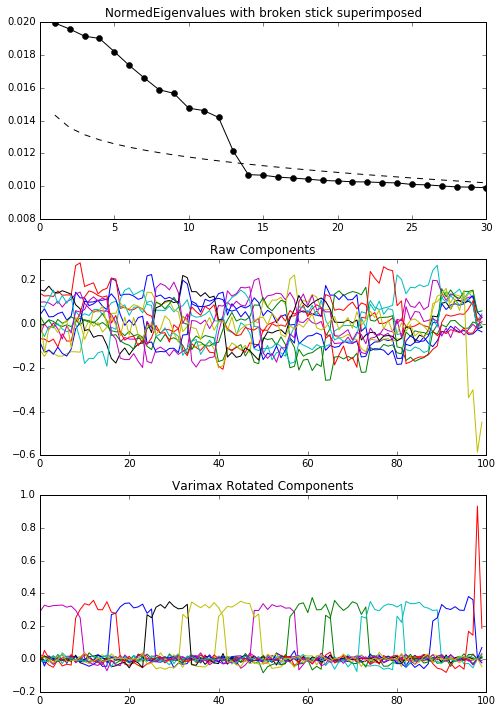

In [7]:
fig_bs = run_pipeline(data, retain_method='broken_stick', rotation_method='varimax')